# LLM detection
## Assignment #3
###  Practical Data Science course, MSc in Data Science (2023/2024)

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Data Augmentation

We begin by reviewing the data provided to us by the competition:

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os


DATA_PATH = os.path.join("..", "data")

In [2]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_essays.csv"))
train_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


Out of these we have been provided with only 3 generated essays:

In [3]:
train_df[train_df.generated == 1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


### Prompting

Unless we procure more data the task is impossible. We will thus use prompting to produce our own generated dataset.

For this task we will use ChatGPT. The prompts were manually given using the official website, and exported the responses in MarkDown form using the very convinient [ChatGPT Conv Down](https://addons.mozilla.org/en-US/firefox/addon/chatgpt-convdown/) Firefox addon. 

We used three prompting strategies to procure our generated dataset:
* The standard prompt (used for the human essays) without sources
* The standard prompt using all the sources, with a role prompt to persuade the model into writing in a more simplistic tone mirroring the tone used in the human essays
* The standard prompt with a role prompt, using a different subset of the sources each time 
* The standard prompt with a role prompt and a different subset of the human essays instead of sources, in order to "mimick" the tone and style of these essays

This procedure was repeated for both types of prompts provided in the dataset (car-free cities and the Electoral College). The conversation context was periodically refreshed in order to avoid the model repeating its own generated essays. Following this procedure we hope to obtain a thorough dataset being as close as possible to the actual operational dataset.

Details on the prompts themselves can be found in `report.pdf`.

### Dataset Caveats

Unfortunately, even following the above strategy does not yield as good results as we would hope for. The biggest isse by far is that ChatGPT's output is formulaic and carries a distinct tone which is most of the time distinct from the students'. 

Role prompting and including human essays as input slightly alleviates the problem but does not eradicate it. Trying to explictly set the tone of the generated essays leads to a complete collapse in tone, with outputs as *artistic* as the one below:

>Dear [Senator's Name],
>
>Hope this letter finds you chill. I wanted to throw my two cents into the mix about the whole Electoral College debate. It's like a hot topic, right? Some say we should keep it, others are all about switching to the popular vote. Here's where I'm at.
>
>So, keeping the Electoral College – it's got its quirks, but it's not all bad. I get it, voting for electors instead of the actual president seems a bit weird. But, like, it's been working, hasn't it? It's like a system our folks set up ages ago, and yeah, maybe it's not perfect, but it's got a rhythm." [...]


In [4]:
import os


OUTPUT_DIR = "..\output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    """
    Save a pandas DataFrame to a CSV file.

    :param df: The DataFrame to be saved.
    :type df: pd.DataFrame

    :param filename: The name of the CSV file.
    :type filename: str

    :return: This function does not return anything.
    :rtype: None
    """
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")


def save_plot(filename: str) -> None:
    """
    Saves a plot to the output directory.

    :param filename: The name of the file for the Figure.
    :type filename: str
    """
    path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

### Importing the generated dataset

In [5]:
def read_gpt(file: str) -> pd.Series:
    """
    Read and extract ChatGPT responses from a file.

    :param file: A string specifying the name of the file to be read.
    :type file: str

    :return: A pandas Series containing ChatGPT responses extracted from the file.
    :rtype: pd.Series
    """
    with open(os.path.join(DATA_PATH, file), encoding="utf8") as f:
        contents = f.read()
    responses = list(filter(lambda x: x.startswith(" ChatGPT"), 
                        contents.split("##")))
    clear_responses = [res.replace("ChatGPT", "").replace("~", "").strip() 
                            for res in responses]
    return pd.Series(clear_responses)


def create_gpt_dataset(input_file_name: str, prompt_id: int):
    data_text = read_gpt("chatgpt_cars.md")
    df = pd.DataFrame({"id": [str(id(text)) for text in data_text],
                             "text": data_text, 
                             "prompt_id": np.full_like(data_text, prompt_id),
                             "generated": np.ones_like(data_text)})
    df.prompt_id = df.prompt_id.astype(int)
    df.generated = df.generated.astype(int)
    return df
    

envir_df = create_gpt_dataset("chatgpt_cars.md", prompt_id=0)
elect_df = create_gpt_dataset("chatgpt_electoral.md", prompt_id=1)

We will export the entire dataset, but will only use a subset of it in training. This is because of the low quality data encountered in the first prompts, where the generated texts do not match the tone or the contents of the human essays.

In [6]:
augmentation_df = pd.concat([envir_df, elect_df])
csv_output(augmentation_df, "augmentation.csv")

File saved successfully as ..\output\augmentation.csv


In [7]:
# discard most low-quality datapoints
df = pd.concat([envir_df[90:], elect_df[90:], train_df])
df

,id,text,prompt_id,generated
90,2058937385968,In the face of escalating environmental concer...,0,1
91,2058937710864,In the wake of growing environmental concerns ...,0,1
92,2058937376704,In the face of pressing environmental concerns...,0,1
93,2058937713920,"In our quest for a sustainable future, limitin...",0,1
94,2058938726128,"In an era marked by environmental concerns, he...",0,1
...,...,...,...,...
1373,fe6ff9a5,There has been a fuss about the Elector Colleg...,1,0
1374,ff669174,Limiting car usage has many advantages. Such a...,0,0
1375,ffa247e0,There's a new trend that has been developing f...,0,0
1376,ffc237e9,As we all know cars are a big part of our soci...,0,0


### Preprocessing

We execute the following preprocessing steps:
* Remove all placeholder tags such as [Your Name], and which are exclusively used by ChatGPT
* Turn all text to lowercase
* Remove stopwords

In [8]:
# sample text
df.text.loc[df.text.apply(lambda x: x.startswith("Dear"))].iloc[3]

"Dear Florida State Senator, Although many could argue that the Electoral College is a fair system of deciding the president, far too many people consider it nondemocratic and inefficient for it it continue being our way of electing our leader. A new system of election must be created to make up for the pitfalls that are inevitable in the Electoral College. A country that is supposed to be a democracy does not have the voting system that such a proud democracy deserves.\n\nDefenders of the College may say that the possibility of a tie is very low or that the electors chosen are confirmed not to betray the wants of the voters, but just because the possibility is low does not mean you can simply allow the flaws in the voting system to exist. A small hole in a fabric can only grow bigger, and the same goes for our electoral college. If we can't repair or replace the fabric that is our Electoral College, soon there will be problems too big for us to deal with in our current state. The elec

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections.abc import Iterable


def remove_stopwords(words: str, stop_words: Iterable[str]) -> str:
    word_tokens = word_tokenize(words)
    # converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    #with no lower case conversion
    filtered_sentence = []
     
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)


def preprocess(text: pd.Series) -> pd.Series:
    bracket_regex = r"\[.*?\]"

    text = text.apply(lambda x: re.sub(bracket_regex, "", x))
    text = text.apply(lambda x: x.lower())

    stop_words = set(stopwords.words('english'))
    text = text.apply(lambda x: remove_stopwords(x, stop_words))
    
    return text

The resulting text resembles the following:

In [10]:
df.text = preprocess(df.text)
df.text.loc[df.text.apply(lambda x: x.startswith("dear"))].iloc[3]

"dear state senator , believe abolish electoral college leave popular vote . electoral college abolished unfair , poses threat u.s constitution . electoral college unfair takes away democratic way society founding fathers set . united states america leave people vote people united states vote someone get run country electoral college decided differently called democracy . example 2000 election al gore gorge w. bush , people united states voted al gore , due electoral college bush election . passage indefensible electoral college says `` 60 % voters would prefer direct election kind . '' tell ? half usa would prefer people vote instead ! furthermore , believe due away electoral college poses threat u.s constitution . say mean threat citizens usa . people united states thought vote president ? majority voters vote someone opponent wins democracy ? also article indefensible electoral college says `` oh state sends two slates electors congress ? happened hawaii 1960. luckily , vice preside

In [11]:
print(f"Number of generated essays in the dataset: {(df.generated == 1).sum()}")

Number of generated essays in the dataset: 129


In [12]:
# check for null values
df.isnull().values.any()

False

We also may need to convert the dataframe's types.

### More augmentation?

Another idea would be to use other standard NLP augmentation techniques such as randomly deleting/inserting words, purposefully inserting typographical mistakes in the text or even [replacing words with close synonyms](https://www.kaggle.com/code/rohitsingh9990/data-augmentation-by-synonym-replacement). However, all of these strategies would ultimately hurt the quality of our dataset, since typos and specific words are very valuable tools in LLM detection.

## Classifiers

In [13]:
print("Downloading Word2Vec model...")

In [14]:
%%capture
!python -m spacy download en_core_web_md

In [15]:
print("Model downloaded.")

Model downloaded.


In [16]:
import spacy


print("Loading Word2Vec model...")
word2vec = spacy.load('en_core_web_md')
print("Model loaded.")

Loading Word2Vec model...
Model loaded.


In [17]:
def compute_embeddings(text: Iterable[str]) -> list[str]:
    embeddings = []
    
    print("Computing embeddings...")
    for text in tqdm(text):
        embeddings.append(word2vec(text).vector)
        
    return embeddings

df["embedding"] = compute_embeddings(df.text)
df

Computing embeddings...


  0%|          | 0/1504 [00:00<?, ?it/s]

,id,text,prompt_id,generated,embedding
90,2058937385968,face escalating environmental concerns need su...,0,1,"[-0.98630893, -0.5552242, -1.8178864, 0.448989..."
91,2058937710864,wake growing environmental concerns imperative...,0,1,"[-1.0448164, -0.6606318, -1.6898832, 0.3931497..."
92,2058937376704,face pressing environmental concerns need sust...,0,1,"[-1.0125891, -0.5684725, -1.8502839, 0.5258781..."
93,2058937713920,"quest sustainable future , limiting car usage ...",0,1,"[-1.062443, -0.6040507, -1.8307492, 0.38176152..."
94,2058938726128,"era marked environmental concerns , health con...",0,1,"[-1.1274812, -0.6483646, -1.7254128, 0.5722238..."
...,...,...,...,...,...
1373,fe6ff9a5,fuss elector college . many people get confuse...,1,0,"[-1.4767352, 0.04409365, -2.265938, 0.2277243,..."
1374,ff669174,limiting car usage many advantages . putting l...,0,0,"[-0.20308205, 0.864372, -3.5353804, 0.25371215..."
1375,ffa247e0,"'s new trend developing years , soon full thro...",0,0,"[-0.80689734, 0.0152280945, -2.0881786, -0.199..."
1376,ffc237e9,know cars big part society today . however car...,0,0,"[-0.65920925, 0.18932514, -2.4064806, -0.80102..."


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_data_from_text(data_train, data_test):
    vectorizer = TfidfVectorizer().fit(data_train.text)
    x_train = vectorizer.transform(data_train.text)
    x_test = vectorizer.transform(data_test.text)
    
    embed_x_train = np.array([x for x in data_train.embedding])
    embed_x_test = np.array([x for x in data_test.embedding])
    
    y_train = data_train.generated.values
    y_test = data_test.generated.values

    return {"vectorizer": vectorizer, 
            "x_train": x_train, 
            "y_train": y_train,
            "x_test": x_test, 
            "y_test": y_test, 
            "embed_x_train": embed_x_train, 
            "embed_x_test": embed_x_test}

In [19]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(df,
                                         train_size=0.7, 
                                         test_size=0.3, 
                                         stratify=df.generated,
                                         random_state=42)

data = get_data_from_text(data_train, data_test)

vectorizer = data["vectorizer"]
x_train = data["x_train"]
x_test = data["x_test"]

embed_x_train = data["embed_x_train"]
embed_x_test = data["embed_x_test"]

y_train = data["y_train"]
y_test = data["y_test"]

The metric we will be using is Macro-F1 average.

- **F1** is a metric used to balance the need for making sure our classifications for a category are both correct (precision) and represent as many of the actual cases of the category as possible (recall).
- **Macro-F1** is the unweighted average of all F1 metrics for each class. We choose Macro F1 instead of a weighted average because we have an unbalanced dataset (Generated essays data are a small fraction of overall essays)


Thus, we want to use a metric which favors both thorough and precise classifiers, and which also assigns equal importance to our smaller classes.

In [20]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    """
    Minor utility method, wraping cross_val_score.
    """
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res.mean(), res.std()

### Dummy Classifier

We will first run a "fake" classifier which only guesses the majority category.

This dummy model thus completely disregards the input features and serves as a useful baseline with which to compare the subsequent classifiers.

In [21]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier


majority_model = DummyClassifier(strategy="most_frequent")
res = cross_val_res(majority_model, x_train, y_train)
print(f"Dummy Classifier mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Dummy Classifier mean macro F1-score 0.4777, std: 0.0001


### Naive Bayes

Naive Bayes is a very cheap and easy-to-interpret classifier, which checks for the probability that each individual word in the text will belong in any language. We generally want to use the simplest model for the job, and so we start with this reliable model which has proven itself in many fields in the past.

The `sklearn` library gives us access to many variations of Naive Bayes, each specialized in its own field. For this NLP task, we will be using `MultinomialNB`, which was suggested by [this blogpost](https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba).

In [22]:
from sklearn.naive_bayes import MultinomialNB


# naive bayes needs dense arrays to work 
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, x_train, y_train)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.8301, std: 0.0384


In [23]:
naive_model = MultinomialNB().fit(x_train, y_train)
naive_res = naive_model.predict(x_test)
print(classification_report(y_test, naive_res, zero_division=0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       413
           1       1.00      0.49      0.66        39

    accuracy                           0.96       452
   macro avg       0.98      0.74      0.82       452
weighted avg       0.96      0.96      0.95       452



### Logistic Regression

LogisticRegression despite its name is a linear classifier, meaning that it attempts to linearly separate the data into distinct categories. This interpretation does not apply well to a NLP task, but means that the classifier retains some very useful properties:

- The solution we get is a global optimum, meaning that it's the best we can get with the provided data. This means no hyper-parameter tuning is necessary and we can use the classifier as-is.
- It's a simple and very easy to compute classifier, since it solves a (mathematically simple) linear problem, albeit with some restrictions (technically those restrictions force it to use gradient descent, but the calculations are much easier than say, a neural network)

In [24]:
from sklearn.linear_model import LogisticRegression
import warnings


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.9836, std: 0.0223


In [25]:
with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, embed_x_train, y_train)
    print(f"Logistic Regression with Word2Vec Embeddings Macro F1-score\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression with Word2Vec Embeddings Macro F1-score
 mean:0.9904, std: 0.0147


In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

print(classification_report(y_test, lr_res, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      0.95      0.97        39

    accuracy                           1.00       452
   macro avg       1.00      0.97      0.99       452
weighted avg       1.00      1.00      1.00       452



### Random Forest

Random Forest is an ensemble algorithm, which means it uses many simpler algorithms which then "vote" on a final decision. It has proven to be a good classifier on complex tasks, it combats overfitting by design (essentially by utilizing random chance in its training phase) and is still fairly easy to interpret.

The drawback is first and foremost computational, since we need to train many smaller classifiers, which may by themselves be computationally expensive (this is somewhat offset by the fact that the classifiers are indepednent and can be computed in parallel). Additionally, Random Forest is a non-parametric method which means that it is generally memory-intensive and may be slow to run on operational data. Finally, we also need to tune hyperparameters.

In [27]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50,
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=5)
print(f"Random Forest Macro F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest Macro F1:
 mean:0.9907, std: 0.0076


In [28]:
forest_model = RandomForestClassifier(n_estimators=50,
                                      criterion="entropy")
res = cross_val_res(forest_model, embed_x_train, y_train)
print(f"Random Forest with Word2Vec Embeddings Macro F1-score\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest with Word2Vec Embeddings Macro F1-score
 mean:0.9904, std: 0.0147


In [29]:
forest_model = RandomForestClassifier(n_estimators=50, 
                                      criterion="entropy").fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
print(classification_report(y_test, forest_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      0.97      0.99        39

    accuracy                           1.00       452
   macro avg       1.00      0.99      0.99       452
weighted avg       1.00      1.00      1.00       452



### Adaboost

Adaboost is the logical conclusion of Random Forests, where each voter considers a very specific "rule" that needs to be followed. The next voter then considers the most important rule to distinguish between the categories for all the clases that the first could not reliably classify, and so on.

This classifier is generally more compact and competent than a simple Random Forest, but is more computationally expensive during training because we cannot train it in parallel.

In [30]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=25)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.9878, std: 0.0042


In [31]:
ada_model = AdaBoostClassifier(n_estimators=25)
res = cross_val_res(ada_model, embed_x_train, y_train, cv=3)
print(f"AdaBoost Macro with Word2Vec Embeddings F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost Macro with Word2Vec Embeddings F1:
 mean:0.9720, std: 0.0157


In [32]:
ada_model = AdaBoostClassifier(n_estimators=25).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
print(classification_report(y_test, ada_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      0.97      0.99        39

    accuracy                           1.00       452
   macro avg       1.00      0.99      0.99       452
weighted avg       1.00      1.00      1.00       452



In [33]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


best_model = ada_model
best_pred = best_model.predict(x_test)
c = make_pipeline(vectorizer, best_model)
explainer = LimeTextExplainer(class_names=best_model.classes_)

Figured saved to ..\output\attribution.png


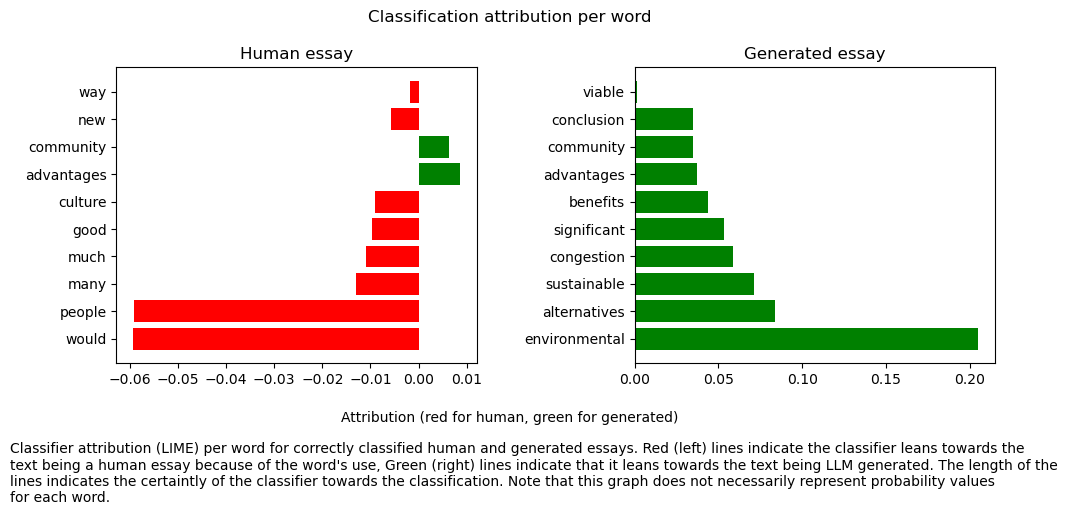

In [34]:
import matplotlib.pyplot as plt
import textwrap


# code for lime text and graph attributed to Ioannis Pavlopoulos
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# explanation for (correct) human classification
example_human = data_test[(data_test.generated == 0) & (best_pred == 0)].head(256)
exp_human = explainer.explain_instance(example_human.text.iloc[0] , c.predict_proba)
exp_human_reversed = [(name, -value) for name, value in exp_human.as_list()]
word_scores_human = pd.DataFrame(exp_human.as_list(), columns=["word", "xscore"]) 
word_scores_human['color'] = word_scores_human.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[0].barh(word_scores_human.word, word_scores_human.xscore, color=word_scores_human.color)
axes[0].set_title("Human essay")

# explanation for generated classification
example = data_test[(data_test.generated == 1) & (best_pred == 1)].head(256)
exp = explainer.explain_instance(example.text.iloc[0] , c.predict_proba)
word_scores = pd.DataFrame(exp.as_list(), columns=["word", "xscore"])
word_scores['color'] = word_scores.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[1].barh(word_scores.word, word_scores.xscore, color=word_scores.color)
axes[1].set_title("Generated essay")

caption_text = "Classifier attribution (LIME) per word for correctly classified human and generated essays. "\
                "Red (left) lines indicate the classifier leans towards the text being a human essay "\
                "because of the word's use, Green (right) lines indicate that it leans towards the text being LLM generated. "\
                "The length of the lines indicates the certaintly of the classifier towards the classification. "\
                "Note that this graph does not necessarily represent probability values for each word."

caption = textwrap.fill(caption_text, width=150)
fig.text(0, -0.25, caption)

fig.suptitle("Classification attribution per word")
fig.text(0.5, -0.05, 'Attribution (red for human, green for generated)', ha='center')
fig.tight_layout(h_pad=3, w_pad=3) #believe it or not this *is* different from pad=3

save_plot("attribution.png")
plt.show()

## Text Similarity

https://www.newscatcherapi.com/blog/ultimate-guide-to-text-similarity-with-python

In [35]:
generated_df = df[df.generated == 1]
human_df = df[df.generated == 0]

generated_docs = []
human_docs = []

In [36]:
def jaccard_similarity(set1: set[str], set2: set[str]) -> float:
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


mean_similarity = []
max_similarity = []

print("Calculating similarity scores...")
for x in tqdm(generated_df.text):
    similarities = []
    for y in human_df.text:
      similarities.append(jaccard_similarity(set(x.split()), set(y.split())))
                                        
    mean_similarity.append(np.mean(similarities))
    max_similarity.append(np.max(similarities))

similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

Calculating similarity scores...


  0%|          | 0/129 [00:00<?, ?it/s]

,id,text,mean,max
90,2058937385968,face escalating environmental concerns need su...,0.046906,0.113208
91,2058937710864,wake growing environmental concerns imperative...,0.041137,0.104615
92,2058937376704,face pressing environmental concerns need sust...,0.043892,0.113846
93,2058937713920,"quest sustainable future , limiting car usage ...",0.040104,0.097983
94,2058938726128,"era marked environmental concerns , health con...",0.038158,0.094688
...,...,...,...,...
151,2058904338032,"today 's fast-paced world , cars considered ne...",0.091258,0.205189
152,2058904378176,limiting car usage emerged revolutionary conce...,0.060222,0.140590
704,82131f68,"essay analyze , discuss prove one reason favor...",0.073079,0.155405
740,86fe4f18,strongly believe electoral college remain way ...,0.077130,0.172840


In [37]:
similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

,id,text,mean,max
90,2058937385968,face escalating environmental concerns need su...,0.046906,0.113208
91,2058937710864,wake growing environmental concerns imperative...,0.041137,0.104615
92,2058937376704,face pressing environmental concerns need sust...,0.043892,0.113846
93,2058937713920,"quest sustainable future , limiting car usage ...",0.040104,0.097983
94,2058938726128,"era marked environmental concerns , health con...",0.038158,0.094688
...,...,...,...,...
151,2058904338032,"today 's fast-paced world , cars considered ne...",0.091258,0.205189
152,2058904378176,limiting car usage emerged revolutionary conce...,0.060222,0.140590
704,82131f68,"essay analyze , discuss prove one reason favor...",0.073079,0.155405
740,86fe4f18,strongly believe electoral college remain way ...,0.077130,0.172840


Figured saved to ..\output\similarity.png


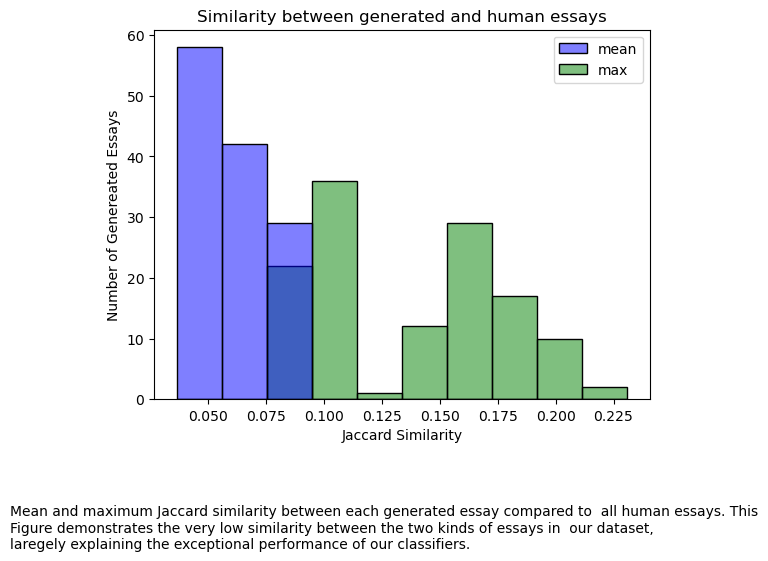

In [38]:
import seaborn as sns
import textwrap


sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"})

caption_text = """Mean and maximum Jaccard similarity between each generated essay compared to 
all human essays. This Figure demonstrates the very low similarity between the two kinds of essays in 
our dataset, laregely explaining the exceptional performance of our classifiers. 
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.2, caption)

plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of Genereated Essays")
plt.title("Similarity between generated and human essays")

save_plot("similarity.png")
plt.show()

In [39]:
probs = []

# TODO: look into this
print("Starting Leave One Out validation for generated texts...")
for essay_id in tqdm(similarity_df.id):
    essay_train = df[~df.id.eq(essay_id)] 
    essay_test = df[df.id.eq(essay_id)]
    assert essay_test.shape[0] == 1, essay_id
    model = RandomForestClassifier(n_estimators=25)
    model = model.fit(vectorizer.transform(essay_train.text), essay_train.generated)
    probs.append(model.predict_proba(vectorizer.transform(essay_test)))

Starting Leave One Out validation for generated texts...


  0%|          | 0/129 [00:00<?, ?it/s]

In [40]:
similarity_df["probs"] = [x[0][0] for x in probs]
similarity_df

,id,text,mean,max,probs
90,2058937385968,face escalating environmental concerns need su...,0.046906,0.113208,1.0
91,2058937710864,wake growing environmental concerns imperative...,0.041137,0.104615,1.0
92,2058937376704,face pressing environmental concerns need sust...,0.043892,0.113846,1.0
93,2058937713920,"quest sustainable future , limiting car usage ...",0.040104,0.097983,1.0
94,2058938726128,"era marked environmental concerns , health con...",0.038158,0.094688,1.0
...,...,...,...,...,...
151,2058904338032,"today 's fast-paced world , cars considered ne...",0.091258,0.205189,1.0
152,2058904378176,limiting car usage emerged revolutionary conce...,0.060222,0.140590,1.0
704,82131f68,"essay analyze , discuss prove one reason favor...",0.073079,0.155405,1.0
740,86fe4f18,strongly believe electoral college remain way ...,0.077130,0.172840,1.0


## Impact of data size

In [41]:
len_splits = np.arange(start=0.1, stop=1.1, step=0.1)
splits = [data_train.sample(int(np.ceil(data_train.shape[0]*i))) for i in len_splits]

sizes = [len(split) for split in splits]
sizes

[106, 211, 316, 421, 526, 632, 737, 842, 947, 1052]

In [42]:
from sklearn.metrics import f1_score


train_scores = []
test_scores = []

for split in splits:
    x_train = vectorizer.transform(split.text)
    y_train = split.generated
    model = RandomForestClassifier(n_estimators=50).fit(x_train, y_train)

    train_preds = model.predict(x_train)
    train_scores.append(f1_score(y_train, train_preds, average="macro"))
    test_preds = model.predict(x_test)
    test_scores.append(f1_score(y_test, test_preds, average="macro"))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Figured saved to ..\output\dataset_size.png


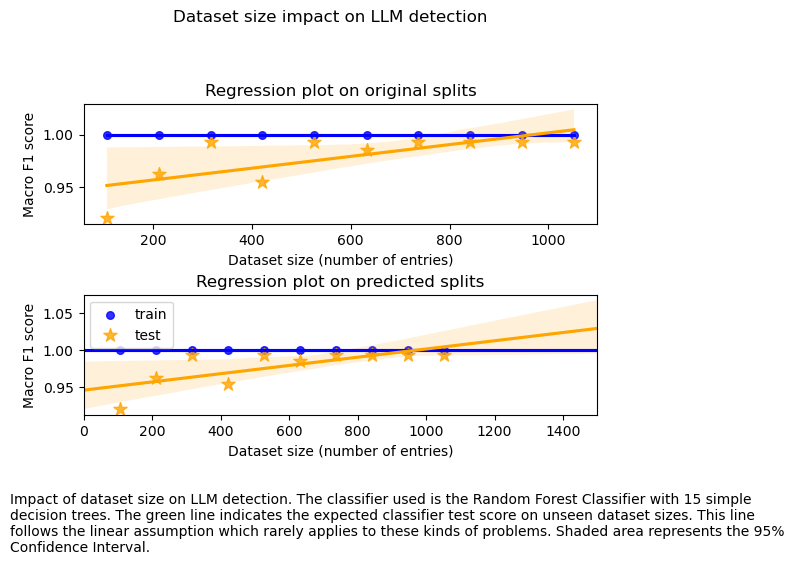

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Dataset size impact on LLM detection")
fig.tight_layout(pad=3)

# regular regplot
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax1,
            scatter_kws={"s": 30})
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax1,
            scatter_kws={"s": 100})

ax1.set_title("Regression plot on original splits")
ax1.set_ylabel("Macro F1 score")
ax1.set_xlabel("Dataset size (number of entries)")
plt.legend()


# regplot with expanded xlim
plt.xlim(0, 1500)
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax2,
            scatter_kws={"s": 30},
            truncate=False)
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax2,
            scatter_kws={"s": 100},
            truncate=False)

ax2.set_title("Regression plot on predicted splits")
ax2.set_ylabel("Macro F1 score")
ax2.set_xlabel("Dataset size (number of entries)")
plt.legend()

# TODO: come back to this once done with data and classifiers
caption_text = "Impact of dataset size on LLM detection. The classifier used is the "\
"Random Forest Classifier with 15 simple decision trees. The green line indicates "\
"the expected classifier test score on unseen dataset sizes. This line follows the "\
"linear assumption which rarely applies to these kinds of problems. Shaded area represents "\
"the 95% Confidence Interval."
caption = textwrap.fill(caption_text, width=110)
plt.figtext(0, -0.15, caption)

# save and show
save_plot("dataset_size.png")
plt.show()

## Clustering-based augmentation

In order to determine the "variance" of our generated samples, we can use clustering techniques to determine 

https://builtin.com/data-science/elbow-method

In [44]:
x_generated = vectorizer.transform(generated_df.text).toarray()
x_human = vectorizer.transform(human_df.text).toarray()

### Clustering Generated Essays

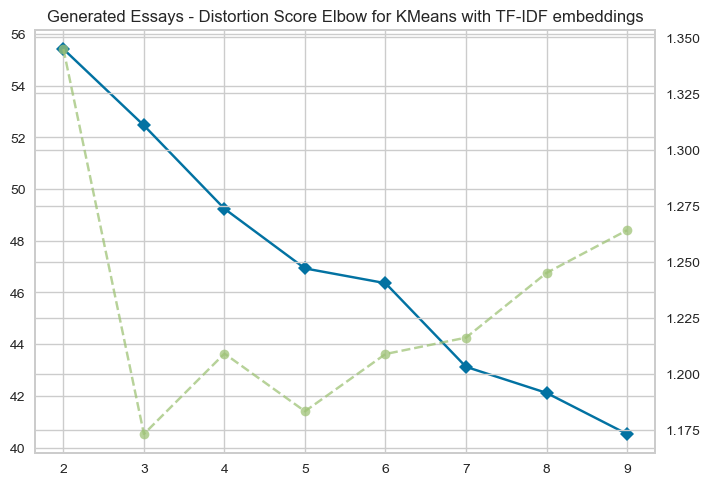

In [45]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# there is an internal memory leak here, don't worry about it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_generated)        
    
plt.title("Generated Essays - Distortion Score Elbow for KMeans with TF-IDF embeddings")
plt.show()

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

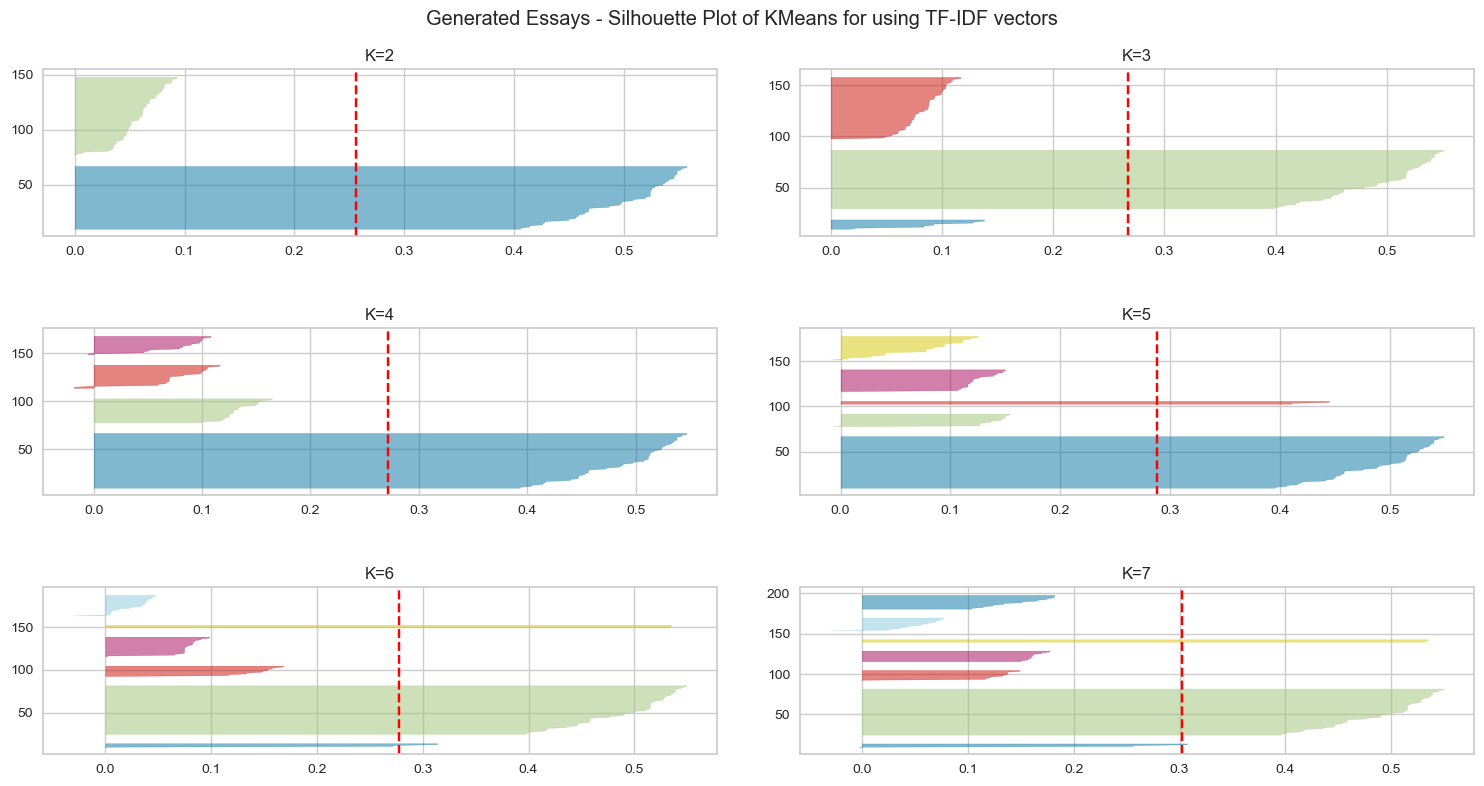

In [46]:
from yellowbrick.cluster import SilhouetteVisualizer


fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    # there is an internal memory leak here, don't worry about it
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_generated) 

fig.suptitle("Generated Essays - Silhouette Plot of KMeans for using TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

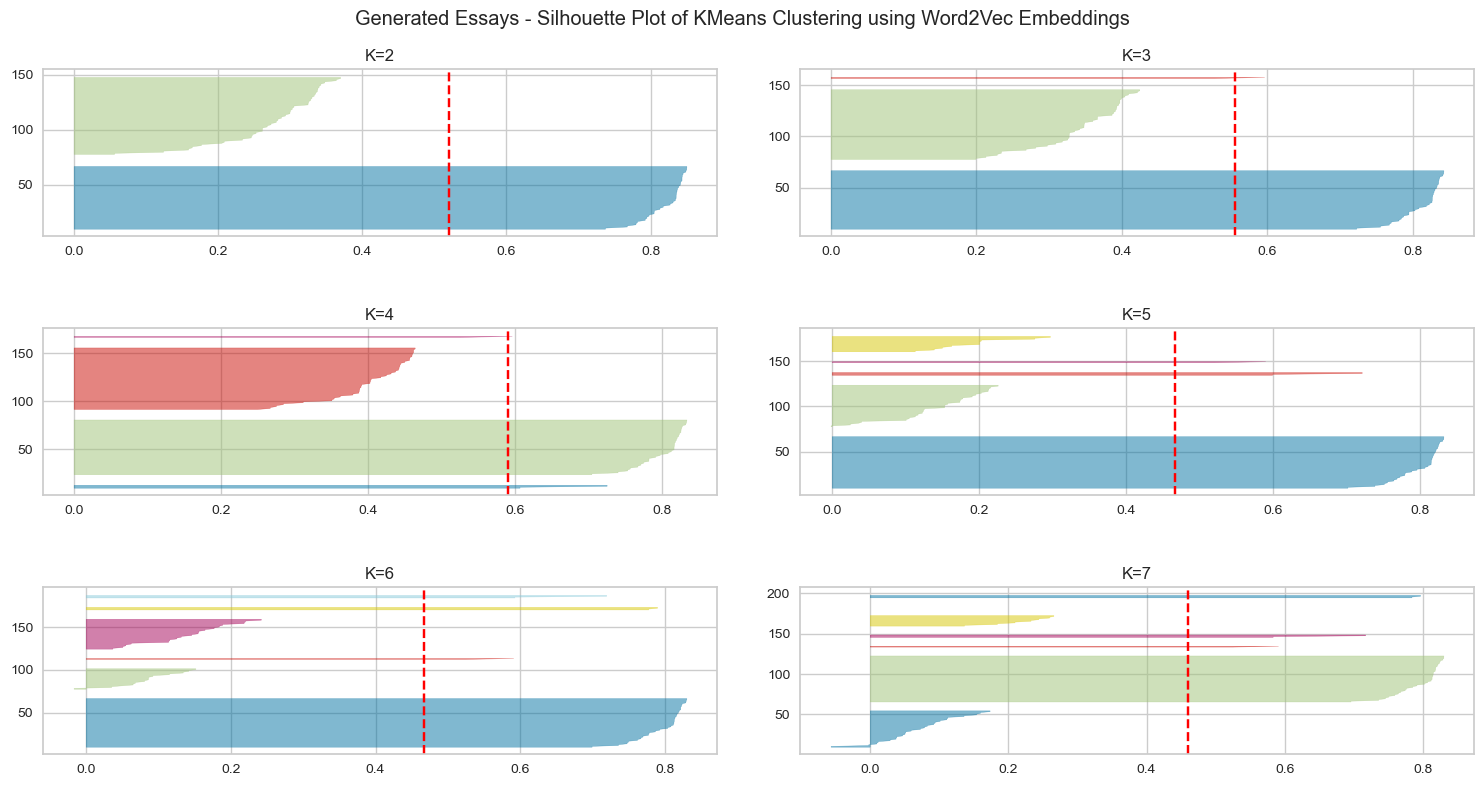

In [47]:
x_embed_generated = np.array([x for x in df.loc[df.generated==1].embedding])
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    # there is an internal memory leak here, don't worry about it
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_embed_generated) 

fig.suptitle("Generated Essays - Silhouette Plot of KMeans Clustering using Word2Vec Embeddings")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

In [48]:
def cluster(n_clusters, data):
    km = KMeans(n_clusters=n_clusters, 
                init="k-means++", 
                random_state=42, 
                n_init=10)
    return km.fit_predict(data)


def print_clusters(clusters, data_df, n_samples=2):
    for cluster in np.unique(clusters):
        print("=" * 100)
        print(f"Cluster {cluster}")
        for text in data_df[clusters==cluster].sample(n_samples).text:
            print("\t\t", text)

In [49]:
generated_clusters = cluster(2, x_generated)
print_clusters(generated_clusters, generated_df)

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0
		 face pressing environmental concerns , urban congestion , economic considerations , advocating limitation car usage emerges transformative strategy numerous advantages communities . drawing insights diverse sources including world health organization ( ) , international energy agency ( iea ) , american automobile association ( aaa ) , essay aims inform fellow citizens multifaceted benefits reducing dependence cars . primarily , restriction car usage addresses critical environmental challenge : air pollution . vehicular emissions , significant contributor poor air quality , recognized detrimental public health . studies indicate limiting car usage substantially decrease harmful emissions , leading improved air quality mitigating health risks . cities london singapore , successfully implemented car restrictions , serve compelling examples positive impact public health environment . moreover , transitioning away excessive car usage aligns broader goal promoting sustainable tr

### Clustering Human Essays

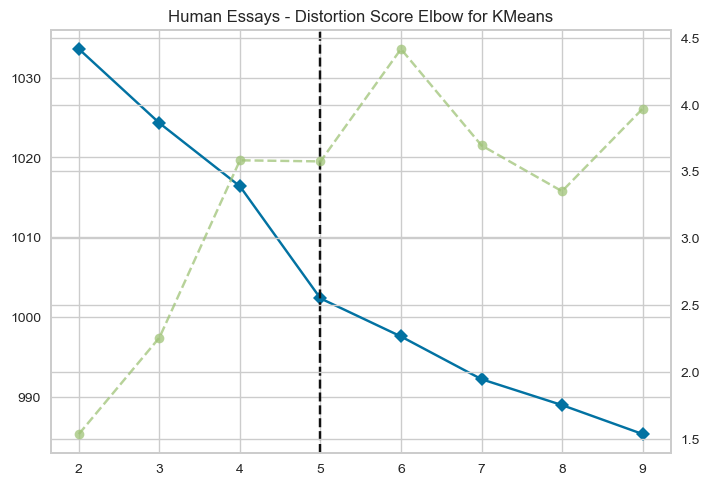

In [50]:
# there is an internal memory leak here, don't worry about it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_human)        
    
plt.title("Human Essays - Distortion Score Elbow for KMeans")
plt.show()

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

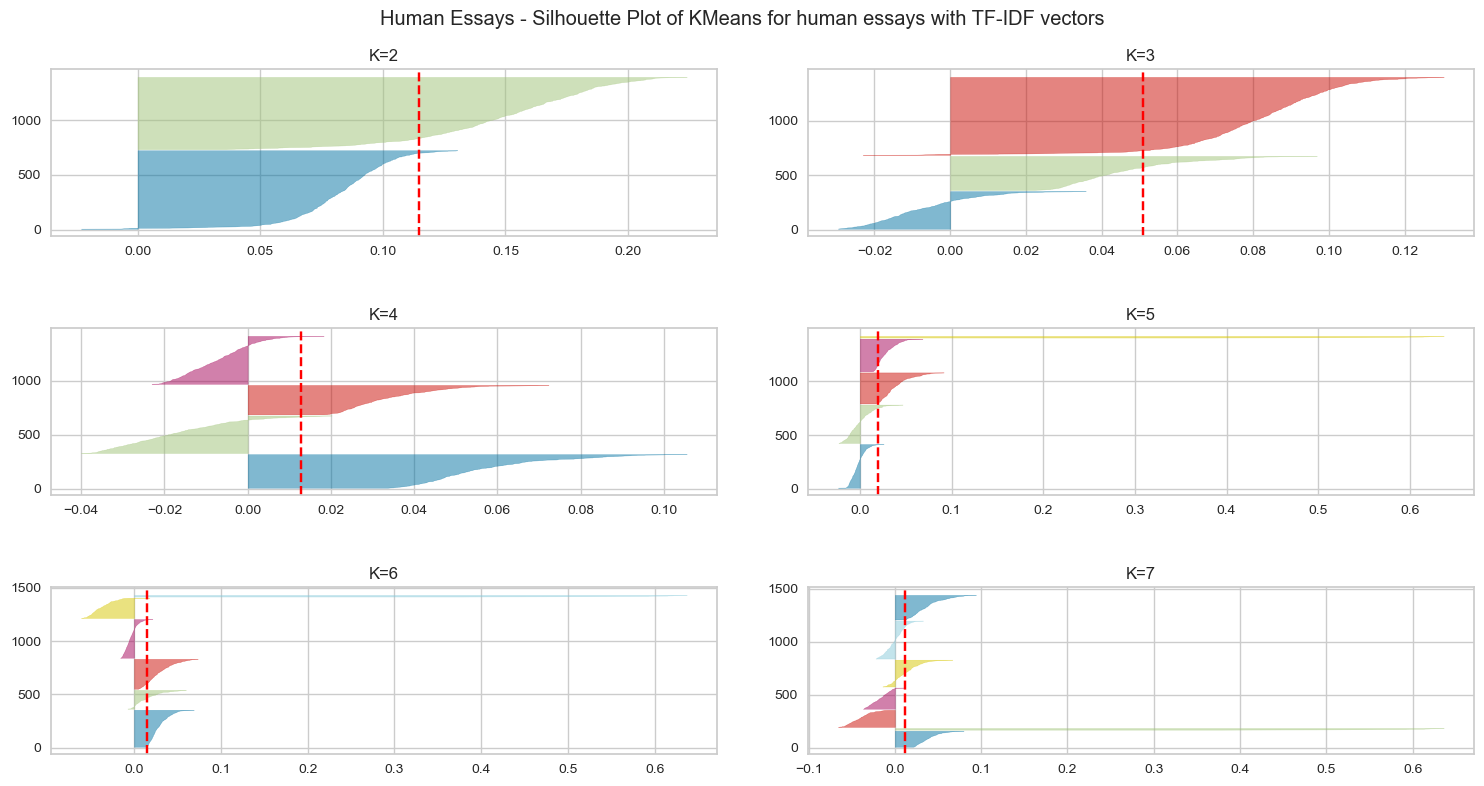

In [51]:
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    # there is an internal memory leak here, don't worry about it
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans for human essays with TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

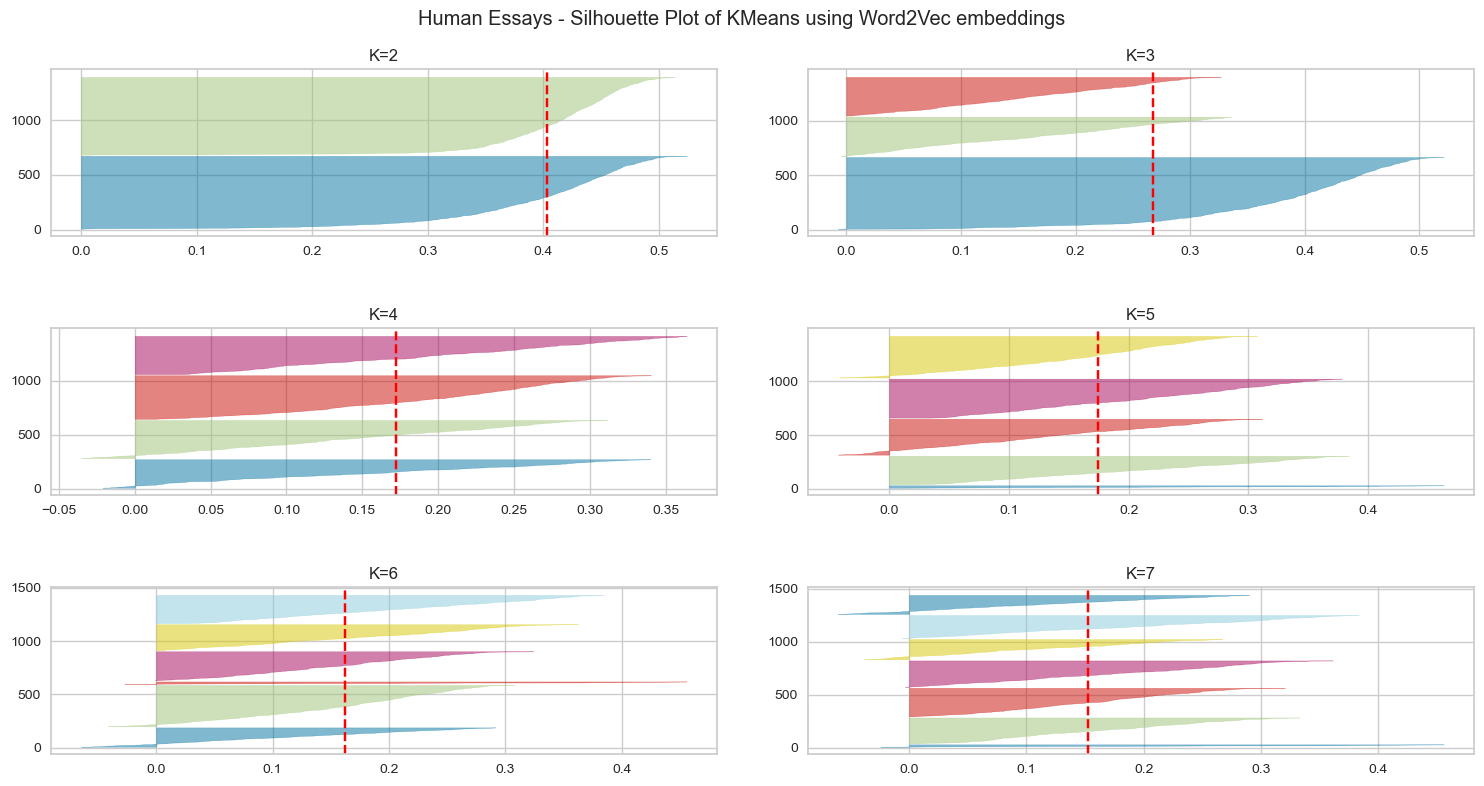

In [52]:
embed_human = np.array([x for x in df.loc[df.generated==0].embedding])
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    # there is an internal memory leak here, don't worry about it
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(embed_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans using Word2Vec embeddings")
fig.tight_layout(h_pad=3, w_pad=3) 
plt.show()

In [53]:
km = KMeans(n_clusters=4, 
                init="k-means++", 
                random_state=42, 
                n_init=10)
km = km.fit(embed_human)
human_clusters = km.predict(embed_human)
print_clusters(human_clusters, human_df)

Cluster 0
		 cars main use transportation one distant destination another . population relying cars often get need . everyone communities becoming lazier bother grab bike even pair skates help get need go . population want walk store usually street . cars even polluting atmosphere causing numerous issues , health problems even rise temperature planet . purpose essay inform fellow citizens advantages limiting car usage . limiting amount cars country even reducing days one use car , dramatically reduce pollution atmosphere also cause citizens become active healthy . `` street parking , driveways home garages generally forbidden experimental new district outskirts freiburg , near french swiss borders . `` source 1 , paragraph 2. vauban one community begin journey becoming car reduced area . `` result , seventy percent vaughn 's families cars , fiftyseven percent sold car move . `` source 1 , paragraph 3. said one residents , `` car always tense . 'm much happier way , '' said heindrun wal

### Augmenting our dataset to balance the clusters

In [54]:
guessed_gen_clusters = km.predict(x_embed_generated)

In [55]:
cluster_df = pd.DataFrame({"clusters": np.concatenate([
                                guessed_gen_clusters, 
                                human_clusters]),
                          "generated": np.concatenate([
                              np.ones_like(guessed_gen_clusters), 
                              np.zeros_like(human_clusters)])})

mapping = {0: "Cars w/sources", 
           1: "Election w/sources",
          2: "Election no sources",
          3: "Cars no sources"}

cluster_df.clusters = cluster_df.clusters.map(mapping)
cluster_df

,clusters,generated
0,Cars w/sources,1
1,Cars w/sources,1
2,Cars w/sources,1
3,Cars w/sources,1
4,Cars w/sources,1
...,...,...
1499,Election no sources,0
1500,Cars no sources,0
1501,Cars w/sources,0
1502,Cars no sources,0


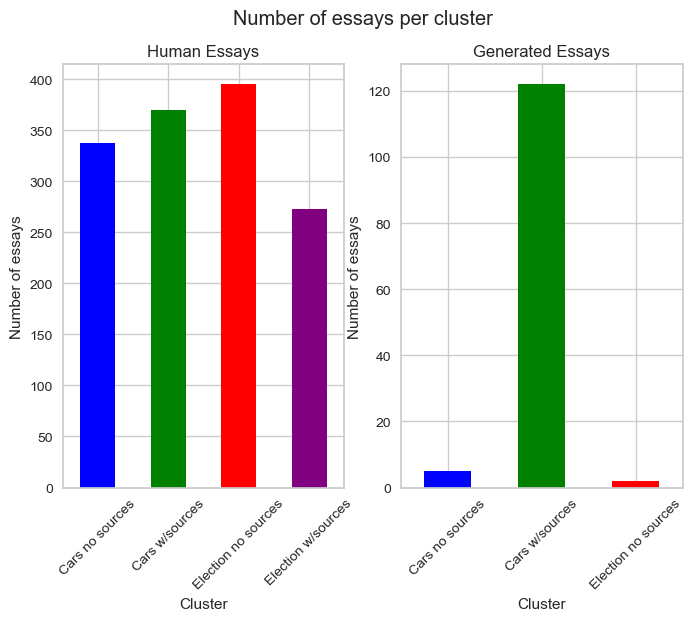

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)

cluster_human_df = cluster_df[cluster_df.generated == 0]
cluster_human_df.clusters.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax1)
ax1.set_title("Human Essays")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of essays")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


gen_human_df = cluster_df[cluster_df.generated == 1]
gen_human_df.clusters.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax2)
ax2.set_title("Generated Essays")
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Number of essays")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

fig.suptitle("Number of essays per cluster")
plt.show()

### Cluster-based augmentation

In [ ]:
extra_cars_df = create_gpt_dataset("cluster_augmentation_cars.md", prompt_id=0)
extra_cars_df.text = preprocess(extra_cars_df.text)
extra_cars_df